# MFCC theory and implementation
## Theory
Mel Frequency Cepstral Coefficents (MFCCs) is a way of extracting features from an audio. The MFCC uses the MEL scale to divide the frequency band to sub-bands and then extracts the Cepstral Coefficents using Discrete Cosine Transform (DCT). MEL scale is based on the way humans distinguish between frequencies which makes it very convenient to process sounds.

Lets first understand how humans perceive sounds.

## Human voice sound perception
Adult humans fundamental voice frequency range is between 85Hz to 255Hz (85Hz to 180Hz for male and 165Hz to 255Hz for female). On top of the fundamental frequency there are harmonics of fundamental frequencys. Harmonics are whole multiplications of the fundamental frequency. If for instance the fundamental frequency is 100Hz then its second harmonic will be 200Hz, third harmonic is 300Hz and so on.

You can see an example in the image below [1] which shows frequency vs. time of several pronounced words and color represents frequency power at that point (yellow strongest and black weakest):
<img src="https://static.scientificamerican.com/sciam/assets/media/sound/speechsep-audio/speechsep-2-spect.png", width=600, height=200>

Notice the first horizontal yellow line on the bottom of each segment. That is the fundamental frequency and its the strongest. Above that there are harmonics with the same frequncy distance from each other.

Humans can hear roughly between 20Hz to 20KHz. The perception of sound is non-linear [2] and you can better distinguish between low frequency sounds than high frequency sounds e.g. humans can clearly hear the difference betwee 100Hz and 200Hz but not between 15kHz and 15.1kHz.

You can try in usin a tone generator: http://www.szynalski.com/tone-generator/

## MEL scale
A MEL scale is a unit of PITCH proposed by Stevens, Volkmann and Newmann in 1937. The MEL scale is a scale of pitches judged by listeners to be equal in distance one from another [3] [4]. Because of how humans perceive sound the MEL scale is a non-lenear scale and the distances between the pitches increeses with frequency.

# MFCC implementation [5] [6]
## Sample signal
First, lets load a sample audio and start working with it:

In [40]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [41]:
TRAIN_PATH = './Datasets/Actor_01/'
ipd.Audio(TRAIN_PATH + "03-02-05-02-02-02-01.wav")

In [68]:
sample_rate, audio = wavfile.read(TRAIN_PATH + "03-02-05-02-02-02-01.wav")
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(audio(len)/sample_rate))

Sample rate: 48000Hz


<ipython-input-68-6ea1c3ca84a1>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wavfile.read(TRAIN_PATH + "03-02-05-02-02-02-01.wav")


TypeError: 'numpy.ndarray' object is not callable

Bonus: notice that the sample rate is 44.1kHz which is the standart sampling rate for audio files. This number is not a coincidence. Acording to Nyquist, that sampling rate of 44.1kHz give us band-width of 22.05kHz. The 0Hz to 22.05kHz zone is called the first Nyquist zone, 22.05kHz to 44.1kHz is the second Nyquist zone and so on. If there is a signal in the second Nyquist zone (lets say 22.1kHz) it will alias to the first Nyquist zone (22kHz in our case). We dont want this to happend so we add a low pass filter (LPF). All LPFs has a pass-band, stop-band and transition band. 

<img src="http://msp.ucsd.edu/techniques/v0.11/book-html/img855.png", width=300, height=1>

The sampling frequency of 44.1kHz was chose so that the transition band will be from 20kHz (pass-band) to 22.05kHz (stop-band). It is important to have at least half of the transition band inside the first Nyquist zone because there is stil not enought attenuetion in the filter in this part so there might be aliases from the second Nyquist zone.

In [ ]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

In [ ]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

There is a lot going on here. It sounds that we should get high and low fundamental frequencies.

## Audio Framing
Because audio is a non stationary process, the FFT will produce distortions. To overcome this we can assume that the audio is a stationary process for a short periods of time. Because of that we devide the signal into short frames. Each audio frame will be the same size as the FFT. Also we want the frames to overlap. We do that so that the frames will have some correlation between them and because we loose the information on the edges of each frame after applying a window function.

In [ ]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [ ]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Now we have framed audio matrix with the size of frame number X FFT size.

In [ ]:
print("First frame:")
audio_framed[1]

In [ ]:
print("Last frame:")
audio_framed[-1]

## Convert to frequency domain
Now we will convert the audio, which is currently in the time domain, to frequency domain. The FFT assumes the audio to be periodic and continues. By framing the signal we assured the audio to be periodic. To make the audio continues, we apply a window function on every frame. If we wont do that, We will get high frequency distortions. To overcome this, we first need to apply a window function to the framed audio and then perforn FFT. The window assures that both ends of the signal will end close to zero.

Choosing the correct window is hard and takes time. For simplicity we will choose the Hanning window. [7]

In [ ]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

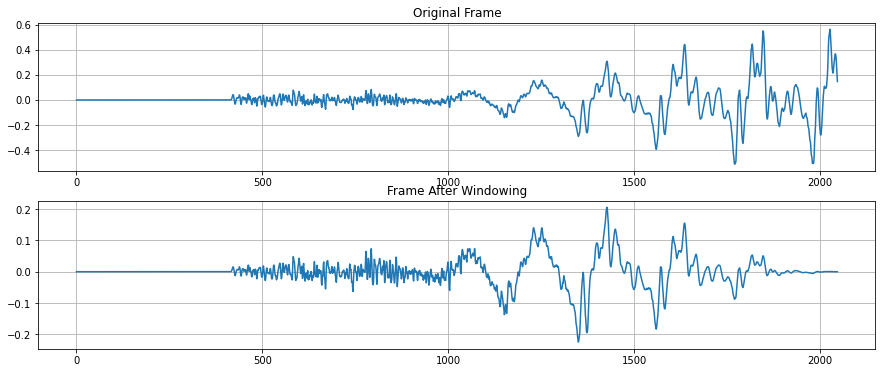

In [69]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In the plot above you can see the that both ends of the frame end on different places on the y axis. You can see that the window brought the edges of each frame closer to zero.

Now lets perform the FFT. After we do the FFT we only take the the positive part of the spectrum (first half +1).

In [70]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

## Calculate signal power

In [71]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(348, 1025)


## MEL-spaced filterbank
Here we compute the MEL-spaced filterbank and then pass the framed audio through them. That will give us information about the power in each frequency band. The filters can be constructed for any frequency band but for our example we will look on the entire sampled band.

What spessial with the MEL-spaced filterbank is the spacing between the filters which grows exponentially with frequency. The filterbank can be made for any frequency band. Here we will compute the filterbank for the entire frequency band.

In [72]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 24000.0


### Compute filter points
First we construct filter points that determines the start and stop of the filters. To do that we first convert the two filterbank edges to the MEL space. After that we construct a lineary spaced array between the two MEL frequencies. Then we convert the array to the frequency space and finally we normalize the array to the FFT size and choose the associated FFT values.

This process is shown in the picture below:

<a href="https://ibb.co/kCsp4H"><img src="https://preview.ibb.co/hrFnrx/MEL.png" alt="MEL" border="0" /></a>

In [73]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [74]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [75]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 4016.019179871836


array([   0,   12,   29,   53,   86,  131,  194,  281,  401,  567,  797,
       1115])

### Construct the filterbank
After we have the filter points, we construct the filters.

In [76]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-3):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

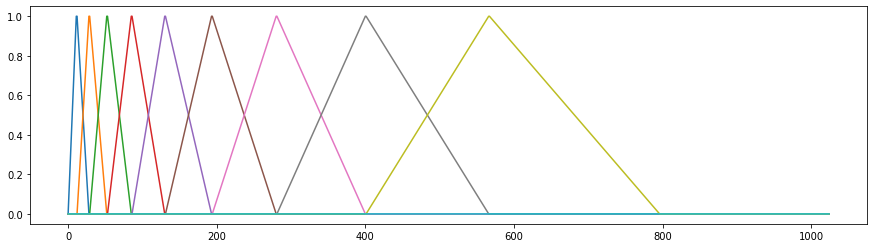

In [77]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

Next we divide the triangular MEL weights by the width of the MEL band (area normalization). If we wont normalize the filters, we will see the noise increase with frequency because of the filter width.

In [78]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

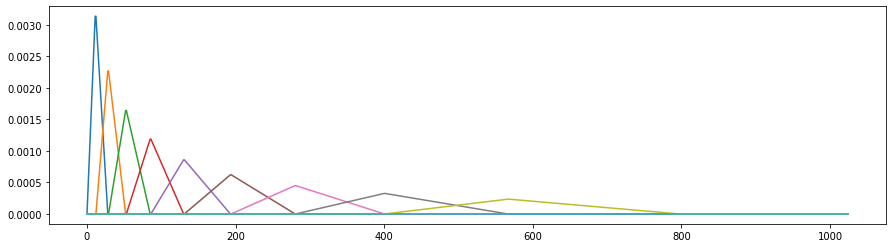

In [79]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

## Filter the signal

In [80]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

<ipython-input-80-535512a2e3ed>:2: RuntimeWarning: divide by zero encountered in log10
  audio_log = 10.0 * np.log10(audio_filtered)


(10, 348)

Now we have a matrix represemting the audio power in all 10 filters in different time frames.
## Generate the Cepstral Coefficents
The final step in generating the MFCC is to use the Discrete Cosine Transform (DCT). We will use the DCT-III. This type of DCT will extract high frequency and low frequency changes in the the signal [8] [9].

In [81]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [82]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 348)

## Reviewing Cepstral coefficents

In [83]:
cepstral_coefficents[:, 0]

array([-inf,  inf, -inf,  inf, -inf,  inf, -inf,  inf, -inf,  inf,  inf,
       -inf,  inf, -inf,  inf, -inf,  inf, -inf,  inf, -inf,  inf, -inf,
        inf, -inf,  inf, -inf,  inf, -inf,  inf, -inf, -inf,  inf, -inf,
        inf, -inf,  inf, -inf,  inf, -inf,  inf])

/home/mustansir/.local/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/mustansir/.local/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


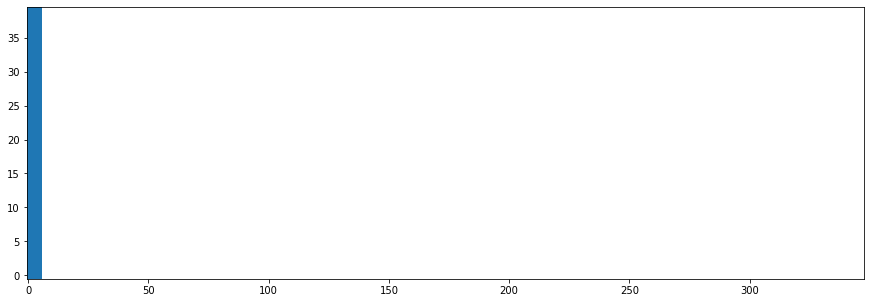

In [84]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

# Conclution
The MFCC is a good algorithm to extract high frequency and low frequency information. There are many parts that can be changed depending on the application. One thing that we might want to check is how the power is scattered across frequency band and choosing the filter amount based on that.

# Bibliography
[1] https://en.wikipedia.org/wiki/Voice_frequency

[2] https://en.wikipedia.org/wiki/Hearing_range

[3] https://www.sfu.ca/sonic-studio/handbook/Mel.html

[4] https://en.wikipedia.org/wiki/Mel_scale

[5] http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

[6] https://librosa.github.io/librosa/

[7] https://en.wikipedia.org/wiki/Window_function#Hamming_window

[8] https://www.youtube.com/watch?v=Q2aEzeMDHMA

[9] https://en.wikipedia.org/wiki/Discrete_cosine_transform